In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
#@title Utilities

import kornia
import torch
import torch.nn as nn
import torch.nn.functional as F
import requests
import PIL
import io
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from IPython.display import Image, HTML, clear_output, display
from ipywidgets import Output
import torch.nn as nn
import src

clear_output()

In [4]:
src.register_easy()

In [5]:
torch.__version__, kornia.__version__

('1.6.0', '0.5.11')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


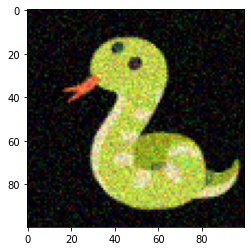

In [34]:
noise = nn.Sequential(
    kornia.augmentation.RandomAffine(
        degrees=0,
        translate=[0.1, 0.1],
        scale=[0.8, 1.1],
#         shear=[-10, 10],
    ),
#     kornia.augmentation.RandomPerspective(0.6, p=1.0),
    kornia.augmentation.RandomGaussianNoise(mean=0.0, std=0.1, p=1),
)

img_np, img_pil = src.load_emoji('🐍')
img_ez_tensor = torch.tensor(img_np).ez.usq().chw.raw
x = torch.cat([img_ez_tensor, torch.rand(1, 10, 100, 100)], dim=1)
noise(x)[:,:].ez.hwc.raw[0,:,:,:3].ez.imshow()

In [37]:
msg_size = 16
ca_depth = 32

encoder = src.CAEncoder(num_chanels=ca_depth)
decoder = src.Decoder(output_size=msg_size)

noisy_channel = src.NoisyChannel(
    msg_size=msg_size,
    seed_shape=[ca_depth, 32, 32],
    encoder=encoder,
    decoder=decoder,
    noise=noise
).to('cuda')

log_loss = []

out = noisy_channel.forward(bs=1, steps=100)
out = out[:,-1,:3,:,:]
out = out.ez.hwc.np[0]
# plt.imshow(out)
out.shape

(32, 32, 3)

In [40]:
vid = src.generate_video(noisy_channel)
vid

In [ ]:
#@title Training {vertical-output: true}
import time

out = Output()
display(out)

tq = tqdm(range(10001))

for i in tq:
    steps = 15 + i // 30
    loss = noisy_channel.training_step(bs=32, steps=steps)
    tq.set_description(f'Loss: {loss:.6f}')
    log_loss.append(loss)

    with out:
        if i % 200 == 0:
            clear_output(wait=True)
            torch.save(noisy_channel, 'model.pk')
            vid = src.generate_video(noisy_channel)
            
            src.plot_loss(log_loss)
            display(vid)

Output()